## Challenge Machine Learning

Asma EL HAFIANE , Elisa DROUOT

Le contexte :

L'objectif de ce défi consiste à développer une méthode de classification reposant sur des réseaux de neurones pour catégoriser des images provenant de Google Quickdraw (https://quickdraw.withgoogle.com/data). Le jeu de données fourni comprend cinq classes équilibrées, comprenant 15 000 exemples d'entraînement et 5 000 exemples de validation. Ces classes sont constituées de paniers, d'yeux, de lunettes, de lapins et de mains.

Pour relever ce défi avec succès, nous allons suivre les étapes fondamentales suivantes :

Importer les images nécessaires pour l'entraînement et la validation, puis les convertir en matrices de pixels. Normaliser les valeurs des pixels de l'image en les divisant par 255. Construire une architecture de modèle séquentielle avec diverses couches. Entraîner le modèle. Évaluer la performance du modèle sur les données de test.

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from PIL import Image
import glob
import matplotlib.pyplot as plt
%matplotlib inline

import os
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

## Préparation de données
Vu que le dossier images qui contient les images pour l'entrainement et la validation du modèle est volumineux, on a décidé finalement de l'importer à travers du drive pour optimiser le temps de l'importation des donnée

Un premier travail a constitué à réaliser la séparation des images en deux catégories : images d'entrainement et images de validation.
Pour cela nous vons réalisé en local un programme python permettant de parcourir les fichier train.csv et valid.csv et de diviser les images.
Voici le code python qui a été réalisé :


    import zipfile
    import io
    import csv
    import shutil
    import os

    chemin_fichier_zip = 'Data_Train_Valid.zip'

    nom_fichier_train_csv = 'train.csv'
    nom_fichier_valid_csv = 'valid.csv'

    # Ouvre le fichier ZIP en mode lecture pour recuperer le fichier excel
    with zipfile.ZipFile(chemin_fichier_zip, 'r') as archive_zip:
        # Lit le contenu du fichier CSV dans une chaîne de caractères
        contenu_train_csv = archive_zip.read(nom_fichier_train_csv).decode('utf-8')
        contenu_valid_csv = archive_zip.read(nom_fichier_valid_csv).decode('utf-8')

    # Utilise  le module csv pour lire le contenu comme un objet CSV
    lecteur_train_csv = csv.reader(io.StringIO(contenu_train_csv))
    lecteur_valid_csv = csv.reader(io.StringIO(contenu_valid_csv))

    #Récupère les images qui sont dans un Dossier Data_Train_Valid extrait du Data_Train_Valid.zip

    destination_train_path = 'Train'
    for index, ligne in enumerate(lecteur_train_csv):
        if index > 0:
            nom_image_train = "Data_Train_Valid/images/" + ligne[1]
            shutil.copy(nom_image_train, destination_train_path)

    destination_valid_path = 'Valid'
    for index, ligne in enumerate(lecteur_valid_csv):
        if index > 0:
            nom_image_valid = "Data_Train_Valid/images/" + ligne[1]
            shutil.copy(nom_image_valid, destination_valid_path)



Nous avons ensuite mit ces données sur un git qu'il était possible de clone:

!git clone "https://gitlab.isima.fr/eldrouot/challenge_machine_learning.git"


Cependant nous nous sommes rendues compte qu'avec cette méthode les labels n'étaient pas récupérés et avons donc utilisé une autre méthode

In [ ]:
# Importation de la fonction drive depuis le module google.colab pour monter Google Drive
from google.colab import drive

# Montage du répertoire Google Drive dans le répertoire /content/drive de l'environnement Colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Commande pour décompresser le fichier zip dans Google Drive
#!unzip "/content/drive/My Drive/Data_Train_Valid.zip"

In [ ]:
# Définition des classes pour la classification des images
classes = ["basket", "eye", "binoculars", "rabbit", "hand"]

# Chargement des données d'entraînement et de validation depuis les fichiers CSV correspondants
train = pd.read_csv('train.csv')
valid = pd.read_csv('valid.csv')

# Définition de la forme attendue des images (28x28 pixels avec 3 canaux de couleur pour RGB)
img_shape = (28, 28, 3)

# Extraction de la taille de l'image sans tenir compte des canaux de couleur (largeur x hauteur)
img_size = img_shape[:2]

# Nombre total de classes dans le problème de classification
num_classes = 5


## Visualisation de données

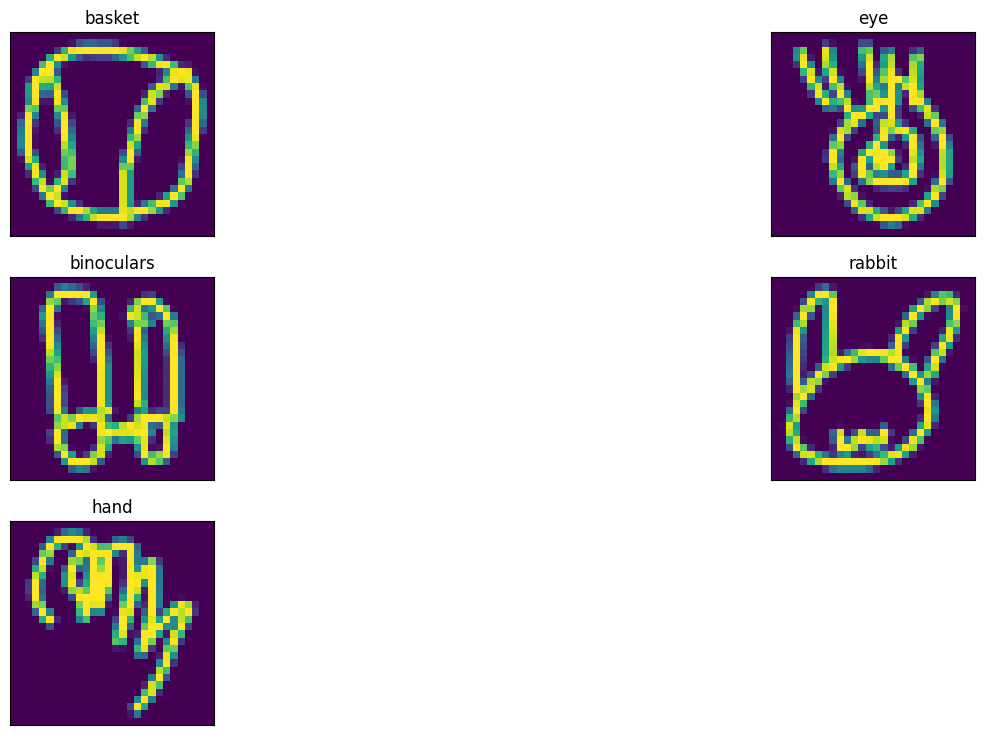

In [ ]:
# Définition de la taille de la figure
plt.figure(figsize=(18, 9))

# Boucle pour afficher des échantillons d'images pour chaque classe
for i in range(0, 5):
    # Définition de l'emplacement de l'image dans la grille
    ax = plt.subplot(3, 2, i + 1)

    # Lecture d'une seule ligne du fichier train.csv pour obtenir le nom du fichier image
    mydata = pd.read_csv("train.csv", skiprows=[1], nrows=1)

    # Ouverture de la première image de la classe actuelle
    im = Image.open('images/' + classes[i] + '/' + os.listdir("images/" + classes[i])[0])

    # Affichage de l'image dans la sous-figure
    fig = ax.imshow(im)

    # Configuration du titre de la sous-figure
    plt.title(classes[i])

    # Désactivation des axes x et y
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

# Affichage de la figure
plt.show()


## Chargement des données
La fonction load_images_and_labels a pour objectif de charger et préparer les données d'entraînement et de validation pour un modèle d'apprentissage automatique. Elle initialise des listes pour stocker les images et les étiquettes, puis parcourt les chemins d'accès aux images dans les données d'entraînement et de validation. Pour chaque image, elle la charge, la convertit en une matrice de pixels, et l'ajoute à la liste correspondante. Enfin, elle divise les données d'entraînement en ensembles d'entraînement et de test à l'aide de train_test_split, puis retourne ces ensembles, ainsi que les images et étiquettes de validation. La fonction sert ainsi à préparer les données pour une utilisation ultérieure dans le processus d'apprentissage du modèle.

In [ ]:
# Importation des fonctions nécessaires
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array

# Définition de la fonction pour charger les images et les étiquettes
def load_images_and_labels(train_data, valid_data, img_size):
    # Initialisation des listes pour stocker les images et les étiquettes d'entraînement
    train_images = []
    train_labels = train_data['class_label']

    # Initialisation des listes pour stocker les images et les étiquettes de validation
    valid_images = []
    valid_labels = valid_data['class_label']

    # Chargement des images d'entraînement
    for train_img_path in train_data['relative_path']:
        try:
            # Construction du chemin complet de l'image d'entraînement
            full_train_img_path = 'images/' + train_img_path

            # Chargement de l'image d'entraînement et conversion en matrice de pixels
            train_img = load_img(full_train_img_path, target_size=img_size)
            train_img_array = img_to_array(train_img)

            # Ajout de la matrice de pixels à la liste des images d'entraînement
            train_images.append(train_img_array)
        except Exception as e:
            print(e)

    # Division des données d'entraînement en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.15, random_state=42)

    # Chargement des images de validation
    for valid_img_path in valid_data['relative_path']:
        try:
            # Construction du chemin complet de l'image de validation
            full_valid_img_path = 'images/' + valid_img_path

            # Chargement de l'image de validation et conversion en matrice de pixels
            valid_img = load_img(full_valid_img_path, target_size=img_size)
            valid_img_array = img_to_array(valid_img)

            # Ajout de la matrice de pixels à la liste des images de validation
            valid_images.append(valid_img_array)
        except Exception as e:
            print(e)

    # Retour des données d'entraînement et de validation
    return X_train, y_train, valid_images, valid_labels, X_test, y_test



In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = load_images_and_labels(train, valid, img_size)

## Prétraitement des données


In [ ]:
# Normalisation des données
X_train_normalized = np.array(X_train) / 255
X_valid_normalized = np.array(X_valid) / 255
X_test_normalized = np.array(X_test) / 255

# Convertir les vecteurs en matrices
Y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes)
Y_valid_categorical = tf.keras.utils.to_categorical(y_valid, num_classes)
Y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes)

# Affichage des formes pour vérification
print('Train shapes      :', X_train_normalized.shape, Y_train_categorical.shape)
print('Valid shapes      :', X_valid_normalized.shape, Y_valid_categorical.shape)
print('Test shapes       :', X_test_normalized.shape, Y_test_categorical.shape)


Train shapes      : (63750, 28, 28, 3) (63750, 5)
Valid shapes      : (25000, 28, 28, 3) (25000, 5)
Test shapes       : (11250, 28, 28, 3) (11250, 5)


# Mise en place du modèle
## Paramètres du modèle

In [ ]:
# Définition du nombre d'époques d'entraînement
num_epochs = 20

# Définition de la taille de lot (batch_size) pour l'entraînement
batch_size = 256

# Définition du chemin pour sauvegarder le modèle
filepath = '/content/drive/My Drive/Challenge_DL.h5'

Nous avons choisis d'utiliser un CNN car les ce type de réseaux permet d'extraire automatiquement et de manière hiérarchique des caractéristiques spatiales complexes à partir des données, ce qui le rend particulièrement adapté à la reconnaissance de motifs dans des images.
En ajoutant plus de couches convolutives, le modèle peut apprendre des hiérarchies de caractéristiques plus complexes. Chaque couche convolutive peut extraire des motifs de plus en plus abstraits dans les données.
Les couches de pooling et les convolutions successives permettent au modèle d'atteindre une certaine invariance spatiale, ce qui signifie qu'il peut reconnaître des motifs même s'ils sont déplacés dans l'image.

    def create_custom_model(input_shape):
        custom_model = tf.keras.Sequential()

        # Première couche de convolution
        custom_model.add(layers.Convolution2D(32, (3, 3),
                              padding='same',
                              input_shape=input_shape, activation='relu'))
        custom_model.add(layers.MaxPooling2D(pool_size=(2, 2)))

        # Deuxième couche de convolution
        custom_model.add(layers.Convolution2D(64, (3, 3), padding='same', activation='relu'))
        custom_model.add(layers.MaxPooling2D(pool_size=(2, 2)))

        # Troisième couche de convolution
        custom_model.add(layers.Convolution2D(128, (3, 3), padding='same', activation='relu'))
        custom_model.add(layers.MaxPooling2D(pool_size=(2, 2)))

        # Aplanir les données
        custom_model.add(layers.Flatten())

        # Couche de régularisation pour prévenir l'overfitting
        custom_model.add(layers.Dropout(0.5))

        # Première couche dense
        custom_model.add(layers.Dense(256, activation='relu'))

        # Deuxième couche dense
        custom_model.add(layers.Dense(128, activation='relu'))

        # Couche de sortie
        custom_model.add(layers.Dense(5, activation='softmax'))

        # Compiler le modèle
        custom_model.compile(loss='categorical_crossentropy',
                            optimizer='Adam',
                            metrics=['accuracy'])

        custom_model.summary()

        return custom_model



## Définition du modèle (CNN)

def create_model(input_shape):
    model = tf.keras.Sequential()

    # Première couche de convolution
    model.add(layers.Convolution2D(32, (3, 3),padding='same',input_shape=input_shape, activation='relu'))

    # Deuxième couche de convolution
    model.add(layers.Convolution2D(64, (3, 3), padding='same', activation='relu'))

    #Pooling
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(.20))
    # Troisième couche de convolution
    model.add(layers.Convolution2D(128, (3, 3), padding='same', activation='relu'))

    # Quatrième couche de convolution
    model.add(layers.Convolution2D(256, (3, 3), padding='same', activation='relu'))

    #Pooling
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Aplanir les données
    model.add(layers.Flatten())

    # Couche de régularisation pour prévenir l'overfitting
    model.add(layers.Dropout(0.5))

    # Première couche dense
    model.add(layers.Dense(128, activation='relu'))

    # Deuxième couche dense
    model.add(layers.Dense(100, activation='relu'))

    # Couche de sortie
    model.add(layers.Dense(5, activation='softmax'))

    # On compile le modèle
    model.compile(loss='categorical_crossentropy',
                         optimizer='Adam',
                         metrics=['accuracy'])

    model.summary()

    return model

Ce modèle et bien moins précis que celui que nous utilisons.

Nous avons également essayé un modèle à 7 couches :

    def create_custom_model(input_shape):
        model = tf.keras.Sequential()

        # Première couche de convolution
        model.add(layers.Convolution2D(32, (3, 3),padding='same',input_shape=input_shape, activation='relu'))

        # Deuxième couche de convolution
        model.add(layers.Convolution2D(64, (3, 3), padding='same', activation='relu'))

        #Pooling
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

        model.add(Dropout(.20))
        # Troisième couche de convolution
        model.add(layers.Convolution2D(128, (3, 3), padding='same', activation='relu'))

        # Quatrième couche de convolution
        model.add(layers.Convolution2D(256, (3, 3), padding='same', activation='relu'))

        #Pooling
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

        # Cinquième couche de convolution
        model.add(layers.Convolution2D(512, (3, 3), padding='same', activation='relu'))

        # Sixième couche de convolution
        model.add(layers.Convolution2D(1024, (3, 3), padding='same', activation='relu'))

        # Septième couche de convolution
        model.add(layers.Convolution2D(2048, (3, 3), padding='same', activation='relu'))

        #Pooling
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

        # Aplanir les données
        model.add(layers.Flatten())

        # Couche de régularisation pour prévenir l'overfitting
        model.add(layers.Dropout(0.5))

        # Première couche dense
        model.add(layers.Dense(128, activation='relu'))

        # Deuxième couche dense
        model.add(layers.Dense(100, activation='relu'))

        # Couche de sortie
        model.add(layers.Dense(5, activation='softmax'))

        # On compile le modèle
        model.compile(loss='categorical_crossentropy',
                            optimizer='Adam',
                            metrics=['accuracy'])

        model.summary()

        return model




Mais ce modèle était bien plus long (14mn pour 20 epochs contre 4mn avec le modèle ci dessous) et avait une plus faible accuracy : 0,9604

Cela est du au fait que l'ajout de couches supplémentaires augmente également la complexité du modèle, ce qui peut entraîner un surajustement si le volume de données d'entraînement est limité c'est pour ça que nous nous sommes limités à 6 couches de convolution.

In [ ]:
## Définition du modèle (CNN)

def create_model(input_shape):
    model = tf.keras.Sequential()

    # Première couche de convolution
    model.add(layers.Convolution2D(32, (3, 3),padding='same',input_shape=input_shape, activation='relu'))

    # Deuxième couche de convolution
    model.add(layers.Convolution2D(64, (3, 3), padding='same', activation='relu'))

    #Pooling
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(.20))
    # Troisième couche de convolution
    model.add(layers.Convolution2D(128, (3, 3), padding='same', activation='relu'))

    # Quatrième couche de convolution
    model.add(layers.Convolution2D(256, (3, 3), padding='same', activation='relu'))

    #Pooling
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Cinquième couche de convolution
    model.add(layers.Convolution2D(128, (3, 3), padding='same', activation='relu'))

    # Sixième couche de convolution
    model.add(layers.Convolution2D(256, (3, 3), padding='same', activation='relu'))

    #Pooling
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Aplanir les données
    model.add(layers.Flatten())

    # Couche de régularisation pour prévenir l'overfitting
    model.add(layers.Dropout(0.5))

    # Première couche dense
    model.add(layers.Dense(128, activation='relu'))

    # Deuxième couche dense
    model.add(layers.Dense(100, activation='relu'))

    # Couche de sortie
    model.add(layers.Dense(5, activation='softmax'))

    # On compile le modèle
    model.compile(loss='categorical_crossentropy',
                         optimizer='Adam',
                         metrics=['accuracy'])

    model.summary()

    return model

In [ ]:
import numpy as np
import tensorflow as tf
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout


# Convertir la liste en un tableau NumPy
X_train_np = np.array(X_train)

# Assurer que les données sont normalisées
X_train_np_normalized = X_train_np / 255.0

# Création du modèle en utilisant la fonction définie précédemment
my_model = create_model(input_shape=X_train_np_normalized.shape[1:])

# Affichage d'un résumé du modèle
my_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 256)       295168    
                                                        

In [ ]:
# Création du callback
checkpoint_callback = ModelCheckpoint(filepath=filepath,
                                       monitor='val_loss',
                                       verbose=2,
                                       save_best_only=True,
                                       mode='min')
callbacks = [checkpoint_callback]

# Entraînement du modèle
history = my_model.fit(X_train_normalized,
                       Y_train_categorical,
                       batch_size=batch_size,
                       epochs=num_epochs,
                       verbose=2,
                       validation_data=(X_valid_normalized, Y_valid_categorical),
                       callbacks=callbacks,
                       use_multiprocessing=True)


Epoch 1/20

Epoch 1: val_loss improved from inf to 0.18071, saving model to /content/drive/My Drive/Challenge_DL.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 - 26s - loss: 0.4500 - accuracy: 0.8404 - val_loss: 0.1807 - val_accuracy: 0.9403 - 26s/epoch - 105ms/step
Epoch 2/20

Epoch 2: val_loss improved from 0.18071 to 0.15703, saving model to /content/drive/My Drive/Challenge_DL.h5
250/250 - 12s - loss: 0.1837 - accuracy: 0.9394 - val_loss: 0.1570 - val_accuracy: 0.9485 - 12s/epoch - 49ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.15703 to 0.13138, saving model to /content/drive/My Drive/Challenge_DL.h5
250/250 - 12s - loss: 0.1395 - accuracy: 0.9536 - val_loss: 0.1314 - val_accuracy: 0.9568 - 12s/epoch - 49ms/step
Epoch 4/20

Epoch 4: val_loss improved from 0.13138 to 0.13049, saving model to /content/drive/My Drive/Challenge_DL.h5
250/250 - 12s - loss: 0.1199 - accuracy: 0.9596 - val_loss: 0.1305 - val_accuracy: 0.9572 - 12s/epoch - 48ms/step
Epoch 5/20

Epoch 5: val_loss improved from 0.13049 to 0.12994, saving model to /content/drive/My Drive/Challenge_DL.h5
250/250 - 12s - loss: 0.1079 - accuracy: 0.9630 - val_loss: 0.1

In [ ]:
# Sauvegarde des poids du modèle
my_model.save_weights('/content/drive/My Drive/weights.h5')

Afin d'analyser le comportement de notre modèle, on va comparer les courbes de loss et les courbes de précision.

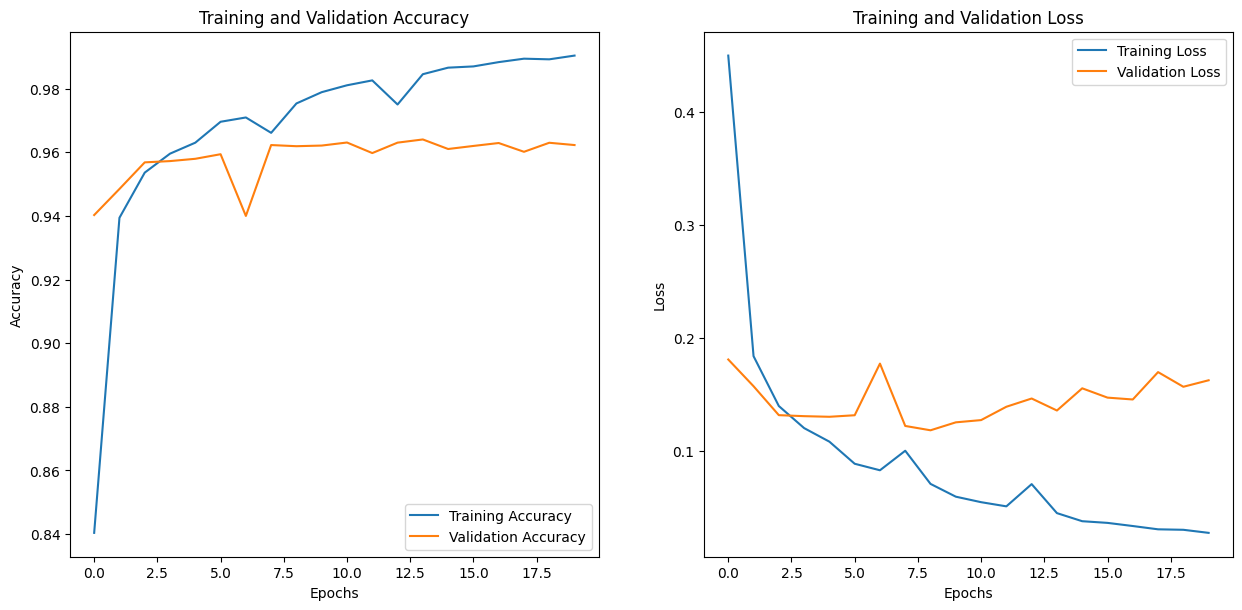

In [ ]:
# Récupération de l'historique d'entraînement
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Traçage des courbes d'entraînement
plt.figure(figsize=(15, 15))

# Courbe de l'accuracy
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la loss
plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Sauvegarde de la figure
plt.savefig('/content/drive/My Drive/model_training_history.png')
plt.show()


Essayons notre modèle sur les données de test :

In [ ]:
from tensorflow.keras.models import load_model

# Chargement du meilleur modèle sauvegardé
best_model = load_model(filepath)

# Affichage du résumé du modèle
best_model.summary()

# Évaluation du modèle sur l'ensemble de test
test_score = best_model.evaluate(X_test_normalized, Y_test_categorical, verbose=1)

# Affichage des résultats
print('Test loss: {:0.2f}%, Test accuracy: {:0.2f}% '.format(test_score[0] * 100, test_score[1] * 100))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 256)       295168    
                                                        

In [ ]:
pip freeze > '/content/drive/My Drive/requirements.txt'